In [1]:
import os
from forg.feature import *

In [2]:
repo_dir = "../data/repos/react"

raw_files: list[RawFile] = []

for dir, _, files in os.walk(repo_dir):
    for file in files:
        path = os.path.join(dir, file)
        raw_files.append(RawFile(path=path, repo_dir=repo_dir))

In [5]:
feature = Feature(device="mps")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
files = feature(raw_files[:100])

Embedding batches: 0it [00:00, ?it/s]
Embedding batches: 0it [00:00, ?it/s]
Embedding batches: 0it [00:00, ?it/s]


In [7]:
from forg.metric import *

target_dist_matrix = tree_distance_matrix(files)  # shape: (N, N)

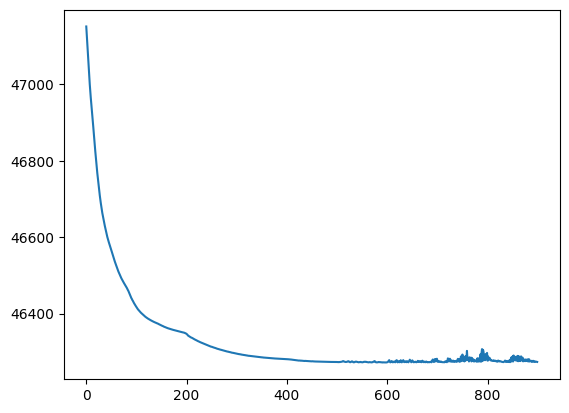

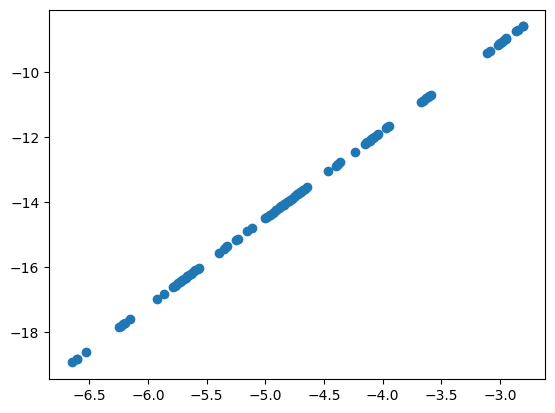

In [6]:
import torch
import matplotlib.pyplot as plt
from forg.embedding import *

embedding = Embedding(feature=feature, D=2, width=2, depth=1)


def loss():
    embeddings = embedding(files)  # shape: (N, D)
    dist_matrix = torch.cdist(embeddings, embeddings)  # shape: (N, N)
    squared_error = (dist_matrix - target_dist_matrix) ** 2
    return squared_error.sum()


# training loop

epochs = 1_000
lr = 0.01

optimizer = torch.optim.Adam(embedding.parameters(), lr=lr)

losses = []

for epoch in range(epochs):
    l = loss()
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(l.item())

plt.plot(losses[100:])
plt.show()

embeddings = embedding(files).cpu().detach()

plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.show()